# OpenFold Colab

Runs a simplified version of [OpenFold](https://github.com/aqlaboratory/openfold) on a target sequence. Adapted from DeepMind's [official AlphaFold Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb).

**Differences to AlphaFold v2.0**

OpenFold is a trainable PyTorch reimplementation of AlphaFold 2. For the purposes of inference, it is practically identical to the original ("practically" because ensembling is excluded from OpenFold (recycling is enabled, however)).

In this notebook, OpenFold is run with your choice of our original OpenFold parameters or DeepMind's publicly released parameters for AlphaFold 2.

**Note**

Like DeepMind's official Colab, this notebook uses **no templates (homologous structures)** and a selected portion of the full [BFD database](https://bfd.mmseqs.com/).

**Citing this work**

Any publication that discloses findings arising from using this notebook should [cite](https://github.com/deepmind/alphafold/#citing-this-work) DeepMind's [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2).

**Licenses**

This Colab supports inference with the [AlphaFold model parameters](https://github.com/deepmind/alphafold/#model-parameters-license), made available under the Creative Commons Attribution 4.0 International ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode)) license. The Colab itself is provided under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0). See the full license statement below.

**More information**

You can find more information about how AlphaFold/OpenFold works in DeepMind's two Nature papers:

*   [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2)
*   [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1)

FAQ on how to interpret AlphaFold/OpenFold predictions are [here](https://alphafold.ebi.ac.uk/faq).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

In [3]:
import os
import s3fs
import boto3
from botocore import UNSIGNED
from botocore.client import Config

import torch
import py3Dmol
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from proteome.models.folding.openfold import data, config
from proteome.models.folding.openfold.data import feature_pipeline
from proteome.models.folding.openfold.data import parsers
from proteome.models.folding.openfold.data import data_pipeline
from proteome.models.folding.openfold.data.tools import jackhmmer
from proteome.models.folding.openfold.model import model
from proteome.models.folding.openfold.np import protein
from proteome.models.folding.openfold.np.relax import relax
from proteome.models.folding.openfold.np.relax.utils import overwrite_b_factors
from proteome.models.folding.openfold.utils.import_weights import import_jax_weights_
from proteome.models.folding.openfold.utils.tensor_utils import tensor_tree_map

/home/conradry71/micromamba/envs/proteome/lib/python3.10/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(
/home/conradry71/micromamba/envs/proteome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sequence = 'MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH'

weight_set = 'OpenFold'
model_dir = './models'
relax_prediction = True

sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
aatypes = set('ACDEFGHIKLMNPQRSTVWY')
if not set(sequence).issubset(aatypes):
    raise Exception(f'Input sequence contains non-amino acid letters: {set(sequence) - aatypes}. OpenFold only supports 20 standard amino acids as inputs.')

In [6]:
s3 = s3fs.S3FileSystem("s3://openfold/")
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
param_files = s3.glob('openfold/openfold_params/*.pt')
os.makedirs(model_dir, exist_ok=True)

for path in param_files:
    save_path = os.path.join(model_dir, os.path.basename(path))
    
    if not os.path.isfile(save_path):
        print("Downloading model", path)
        s3_bucket, s3_key = path.split('/')[0], '/'.join(path.split('/')[1:])
        with open(save_path, mode='wb') as f:
            client.download_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)

## Sequence MSA search

In [8]:
jackhmmer_binary_path = os.environ["JACKHMMER_PATH"]
num_jackhmmer_chunks = {'uniref90': 59, 'smallbfd': 17, 'mgnify': 71}
total_jackhmmer_chunks = sum(num_jackhmmer_chunks.values())

Smartly pick the jackhammer path from the activate conda environment path. Create a temp directory called proteome that's definitely accessible

In [ ]:
dbs = []
jackhmmer_uniref90_runner = jackhmmer.Jackhmmer(
    binary_path=jackhmmer_binary_path,
    database_path=f'https://storage.googleapis.com/alphafold-colab-asia/latest/uniref90_2021_03.fasta',
    get_tblout=True,
    num_streamed_chunks=num_jackhmmer_chunks['uniref90'],
    streaming_callback=None,
    z_value=135301051
)
dbs.append(('uniref90', jackhmmer_uniref90_runner.query('target.fasta')))

jackhmmer_smallbfd_runner = jackhmmer.Jackhmmer(
    binary_path=jackhmmer_binary_path,
    database_path='https://storage.googleapis.com/alphafold-colab-asia/latest/bfd-first_non_consensus_sequences.fasta',
    get_tblout=True,
    num_streamed_chunks=num_jackhmmer_chunks['smallbfd'],
    streaming_callback=None,
    z_value=65984053
)
dbs.append(('smallbfd', jackhmmer_smallbfd_runner.query('target.fasta')))

jackhmmer_mgnify_runner = jackhmmer.Jackhmmer(
    binary_path=jackhmmer_binary_path,
    database_path=f'https://storage.googleapis.com/alphafold-colab-asia/latest/mgy_clusters_2019_05.fasta',
    get_tblout=True,
    num_streamed_chunks=num_jackhmmer_chunks['mgnify'],
    streaming_callback=None,
    z_value=304820129
)
dbs.append(('mgnify', jackhmmer_mgnify_runner.query('target.fasta')))

In [49]:
#import pickle
#with open("seq_db_results.pkl", mode="wb") as handle:
#    pickle.dump(dbs, handle)

In [9]:
import pickle
with open("seq_db_results.pkl", mode="rb") as handle:
    dbs = pickle.load(handle)

58 Sequences Found in uniref90
110 Sequences Found in smallbfd
9 Sequences Found in mgnify

173 Sequences Found in Total



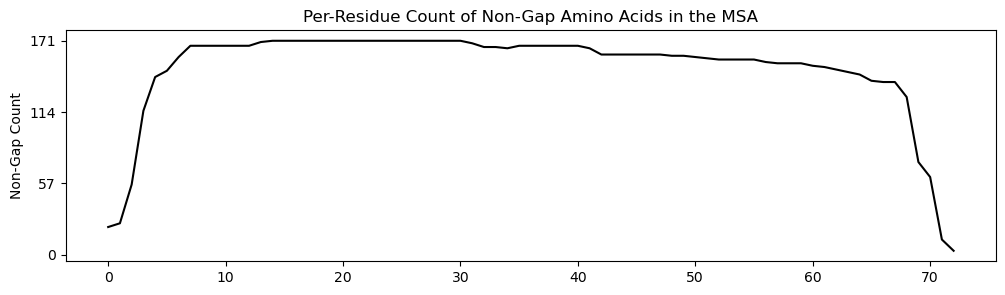

In [10]:
mgnify_max_hits = 501

msas = []
deletion_matrices = []
full_msa = []

for db_name, db_results in dbs:
    unsorted_results = []
    for i, result in enumerate(db_results):
        msa, deletion_matrix, target_names = parsers.parse_stockholm(result['sto'])
        e_values_dict = parsers.parse_e_values_from_tblout(result['tbl'])
        e_values = [e_values_dict[t.split('/')[0]] for t in target_names]
        zipped_results = zip(msa, deletion_matrix, target_names, e_values)
        if i != 0:
            # Only take query from the first chunk
            zipped_results = [x for x in zipped_results if x[2] != 'query']
        unsorted_results.extend(zipped_results)
        
    sorted_by_evalue = sorted(unsorted_results, key=lambda x: x[3])
    db_msas, db_deletion_matrices, _, _ = zip(*sorted_by_evalue)
    if db_msas:
        if db_name == 'mgnify':
            db_msas = db_msas[:mgnify_max_hits]
            db_deletion_matrices = db_deletion_matrices[:mgnify_max_hits]
            
        full_msa.extend(db_msas)
        msas.append(db_msas)
        deletion_matrices.append(db_deletion_matrices)
        msa_size = len(set(db_msas))
        print(f'{msa_size} Sequences Found in {db_name}')

deduped_full_msa = list(dict.fromkeys(full_msa))
total_msa_size = len(deduped_full_msa)
print(f'\n{total_msa_size} Sequences Found in Total\n')

aa_map = {restype: i for i, restype in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ-')}
msa_arr = np.array([[aa_map[aa] for aa in seq] for seq in deduped_full_msa])
num_alignments, num_res = msa_arr.shape

fig = plt.figure(figsize=(12, 3))
plt.title('Per-Residue Count of Non-Gap Amino Acids in the MSA')
plt.plot(np.sum(msa_arr != aa_map['-'], axis=0), color='black')
plt.ylabel('Non-Gap Count')
plt.yticks(range(0, num_alignments + 1, max(1, int(num_alignments / 3))))
plt.show()

## Predict Structure

In [11]:
def _placeholder_template_feats(num_templates_, num_res_):
    return {
        'template_aatype': np.zeros((num_templates_, num_res_, 22), dtype=np.int64),
        'template_all_atom_positions': np.zeros((num_templates_, num_res_, 37, 3), dtype=np.float32),
        'template_all_atom_mask': np.zeros((num_templates_, num_res_, 37), dtype=np.float32),
        'template_domain_names': np.zeros((num_templates_,), dtype=np.float32),
        'template_sum_probs': np.zeros((num_templates_, 1), dtype=np.float32),
    }
    
output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

plddts = {}
pae_outputs = {}
unrelaxed_proteins = {}

num_templates = 1 # dummy number --- is ignored
num_res = len(sequence)

feature_dict = {}
feature_dict.update(data_pipeline.make_sequence_features(sequence, 'test', num_res))
feature_dict.update(data_pipeline.make_msa_features(msas, deletion_matrices=deletion_matrices))
feature_dict.update(_placeholder_template_feats(num_templates, num_res))

cfg = config.model_config(name="model_1")
openfold_model = model.AlphaFold(cfg)

pipeline = feature_pipeline.FeaturePipeline(cfg.data)
processed_feature_dict = pipeline.process_features(
  feature_dict, mode='predict'
)
processed_feature_dict = tensor_tree_map(
    lambda t: t.cuda(), processed_feature_dict
)

In [12]:
weights = torch.load('./models/finetuning_3.pt', map_location="cpu")
openfold_model.load_state_dict(weights)

<All keys matched successfully>

In [13]:
openfold_model = openfold_model.cuda()
openfold_model.eval()
with torch.no_grad():
    res = openfold_model(processed_feature_dict)

In [14]:
mean_plddt = res['plddt'].mean()
final_atom_mask = res['final_atom_mask']
b_factors = res['plddt'][:, None] * final_atom_mask
unrelaxed_protein = protein.from_prediction(
  processed_feature_dict, res, b_factors=b_factors
)
unrelaxed_protein_dict = {k: getattr(unrelaxed_protein, k).cpu().numpy() for k in ['atom_positions', 'aatype', 'atom_mask', 'residue_index', 'b_factors']}
unrelaxed_protein_dict['aatype'] = unrelaxed_protein_dict['aatype'][:, 0]
unrelaxed_protein_dict['residue_index'] = unrelaxed_protein_dict['residue_index'][:, 0]
unrelaxed_protein = protein.Protein(**unrelaxed_protein_dict)

In [15]:
best_pdb = protein.to_pdb(unrelaxed_protein)

In [ ]:
amber_relaxer = relax.AmberRelaxation(
    max_iterations=0,
    tolerance=2.39,
    stiffness=10.0,
    exclude_residues=[],
    max_outer_iterations=20,
    use_gpu=False,
)
relaxed_pdb, _, _ = amber_relaxer.process(
    prot=unrelaxed_protein, cif_output=False
)
best_pdb = relaxed_pdb

In [ ]:
# Write out the prediction
with open('prediction/selected_prediction.pdb', 'w') as f:
    f.write(best_pdb)

In [ ]:
PLDDT_BANDS = [
  (0, 50, '#FF7D45'),
  (50, 70, '#FFDB13'),
  (70, 90, '#65CBF3'),
  (90, 100, '#0053D6')
]
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(best_pdb)
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}

style['stick'] = {}

view.setStyle({'model': -1}, style)
view.zoomTo()